In [3]:
import torch
import os
import matplotlib.pyplot as plt
from diffusers import StableDiffusionPipeline
#from google.colab import drive

#drive.mount('/content/drive')
#print(os.getcwd())
#os.chdir('/content/drive/My Drive/diffusion_project/ovam-main') #or wherever it is

from ovam import StableDiffusionHooker
from ovam.utils import set_seed, get_device
from ovam.optimize import optimize_embedding

In [4]:
model_id = "runwayml/stable-diffusion-v1-5"
device = get_device()

pipe = StableDiffusionPipeline.from_pretrained(model_id)
pipe = pipe.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
if True:
    from PIL import Image
    with StableDiffusionHooker(pipe, extract_self_attentions=True) as hooker:
        set_seed(123456)
        out = pipe(prompt="a photograph of a cat in a park")
        image = out.images[0]

    # Load annotation of the cat
    cat_annotation = Image.open("Copy of cat_annotation.png")
    with torch.no_grad():
        attention_maps = ovam_evaluator("a photograph of a cat in a park")
        attention_maps = attention_maps[0].cpu().numpy() # (8, 512, 512)


    cat_target = (np.array(cat_annotation).sum(axis=-1) > 0).astype(np.float32)  # (512, 512)
    cat_target = np.clip(attention_maps[5] > np.mean(attention_maps[5] +50), 0, 1).astype(np.float32)
    cat_target = torch.tensor(cat_target).to(device)
    cat_target = torch.stack([1 - cat_target, cat_target], dim=0).unsqueeze(0)  # (n_tokens=2, 512, 512)
    print(cat_target.shape)
    # Get the OVAM evaluator
    ovam_evaluator = hooker.get_ovam_callable(expand_size=(512, 512))

    # Initalize a X' with <SoT> and "cat" tokens (2, 768)
    embedding = ovam_evaluator.encode_text(
        text="cat",
        context_sentence="a photograph of a cat in a park",
        remove_special_tokens=False,)[:-1]  # This returns <Sot> + Cat + <Eot> tokens. Eot is removed.


    # Optimize the embedding
    embedding = optimize_embedding(
        ovam_evaluator,
        embedding=embedding, # Initial embedding
        target=cat_target, # Target mask
        device=device, # Device
    )

    with torch.no_grad():
        optimized_map = ovam_evaluator(embedding.to(device)).squeeze().cpu().numpy()[1] # (512, 512)
        non_optimized_map = ovam_evaluator("cat").squeeze().cpu().numpy()[1] # (512, 512)

    # Plot result using
    fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(14, 4))
    ax0.imshow(image)
    ax0.axis("off")
    ax0.set_title("Synthetized image")
    ax1.set_title("Target mask")
    ax1.imshow(cat_target[-1][-1].cpu())
    ax1.axis("off")
    ax2.set_title("Attention of word cat")
    ax2.imshow(non_optimized_map)
    ax2.axis('off')
    ax3.set_title("Optimized attention for cat")
    ax3.imshow(optimized_map)
    ax3.axis('off')
    fig.tight_layout()

  0%|          | 0/50 [00:00<?, ?it/s]

In [28]:
from PIL import Image
import numpy as np
with StableDiffusionHooker(pipe, extract_self_attentions=True) as hooker:
    set_seed(123455)
    out = pipe(prompt="a photograph of the face of a man")
    image = out.images[0]


with torch.no_grad():
    attention_maps = ovam_evaluator("a photograph of the face of a man")
    attention_maps = attention_maps[0].cpu().numpy() # (len_prompt + 2, 512, 512)

#non_optimized_map = ovam_evaluator("male").detach().squeeze().cpu().numpy()
#abc = non_optimized_map[1]>(np.mean(non_optimized_map[1]) + 2)
abc = attention_maps[-2] > (np.mean(attention_maps[-2]))

cat_target = np.clip(attention_maps[-2] > np.mean(attention_maps[-2]), 0, 1).astype(np.float32)
cat_target = torch.tensor(cat_target).to(device)
cat_target = torch.stack([1 - cat_target, cat_target], dim=0).unsqueeze(0)  # (n_tokens=2, 512, 512)

# Get the OVAM evaluator
ovam_evaluator = hooker.get_ovam_callable(expand_size=(512, 512))

# Initalize a X' with <SoT> and "cat" tokens (2, 768)
embedding = ovam_evaluator.encode_text(
    text="male",
    context_sentence="a photograph of the face of a man",
    remove_special_tokens=False,)[:-1]  # This returns <Sot> + Cat + <Eot> tokens. Eot is removed.


# Optimize the embedding
embedding = optimize_embedding(
    ovam_evaluator,
    embedding=embedding, # Initial embedding
    target=cat_target, # Target mask
    device=device, # Device
)

with torch.no_grad():
    optimized_map = ovam_evaluator(embedding.to(device)).squeeze().cpu().numpy()[1] # (512, 512)
    non_optimized_map = ovam_evaluator("male").squeeze().cpu().numpy()[1] # (512, 512)

# Plot result using
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(14, 4))
ax0.imshow(image)
ax0.axis("off")
ax0.set_title("Synthetized image")
ax1.set_title("Target mask")
ax1.imshow(cat_target[-1][-1].cpu())
ax1.axis("off")
ax2.set_title("Attention of word man")
ax2.imshow(non_optimized_map)
ax2.axis('off')
ax3.set_title("Optimized attention for man")
ax3.imshow(optimized_map)
ax3.axis('off')
fig.tight_layout()


  0%|          | 0/50 [00:00<?, ?it/s]

RuntimeError: only batches of spatial targets supported (3D tensors) but got targets of size: : [1, 2, 512, 512]

In [32]:
abc = attention_maps[-2] > (np.mean(attention_maps[-2]))

cat_target = np.clip(attention_maps[-2] > np.mean(attention_maps[-2]), 0, 1).astype(np.float32)
cat_target = torch.tensor(cat_target).to(device)
cat_target = torch.stack([1 - cat_target, cat_target], dim=0).unsqueeze(0)  # (n_tokens=2, 512, 512)

# Get the OVAM evaluator
ovam_evaluator = hooker.get_ovam_callable(expand_size=(512, 512))

# Initalize a X' with <SoT> and "cat" tokens (2, 768)
embedding = ovam_evaluator.encode_text(
    text="male",
    context_sentence="a photograph of the face of a man",
    remove_special_tokens=False,)  # This returns <Sot> + Cat + <Eot> tokens. Eot is removed.


# Optimize the embedding
embedding = optimize_embedding(
    ovam_evaluator,
    embedding=embedding, # Initial embedding
    target=cat_target, # Target mask
    device=device, # Device
)


with torch.no_grad():
    optimized_map = ovam_evaluator(embedding.to(device)).squeeze().cpu().numpy()[1] # (512, 512)
    non_optimized_map = ovam_evaluator("male").squeeze().cpu().numpy()[1] # (512, 512)

# Plot result using
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(14, 4))
ax0.imshow(image)
ax0.axis("off")
ax0.set_title("Synthetized image")
ax1.set_title("Target mask")
ax1.imshow(cat_target[-1][-1].cpu())
ax1.axis("off")
ax2.set_title("Attention of word man")
ax2.imshow(non_optimized_map)
ax2.axis('off')
ax3.set_title("Optimized attention for man")
ax3.imshow(optimized_map)
ax3.axis('off')
fig.tight_layout()

np.save('optimal_male_embedding.npy', embedding)

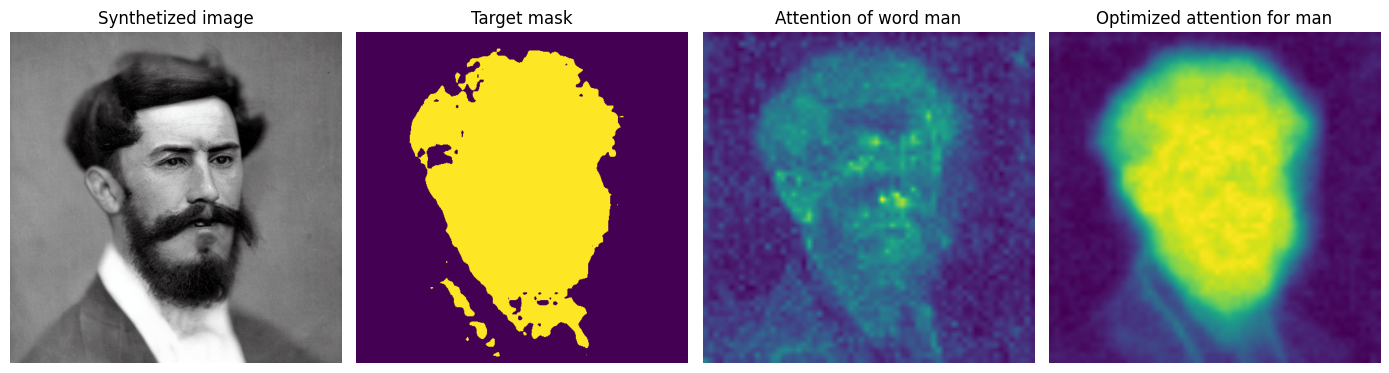

  0%|          | 0/50 [00:00<?, ?it/s]

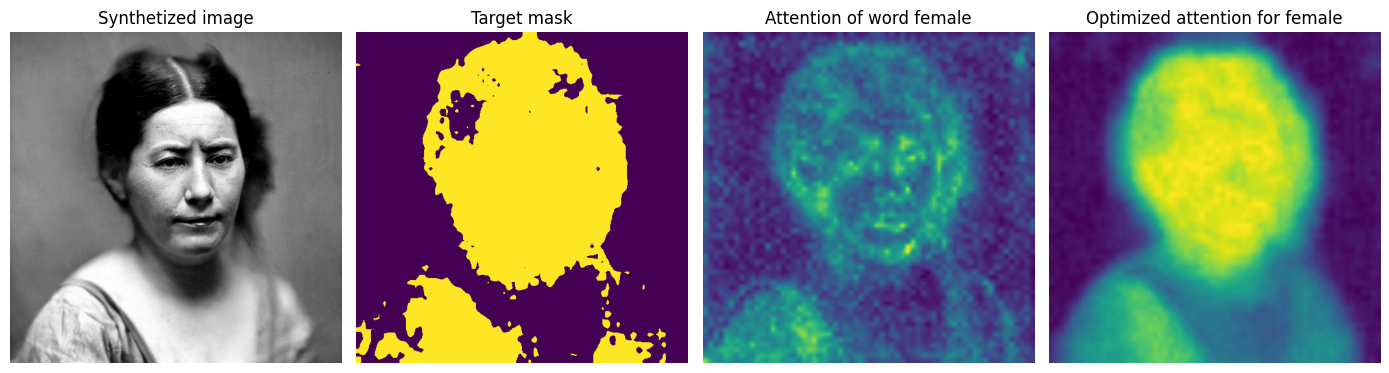

In [35]:
from PIL import Image
with StableDiffusionHooker(pipe, extract_self_attentions=True) as hooker:
    set_seed(123455)
    out = pipe(prompt="a photograph of the face of a woman")
    image = out.images[0]


ovam_evaluator = hooker.get_ovam_callable(expand_size=(512, 512))
with torch.no_grad():
    attention_maps = ovam_evaluator("a photograph of the face of a woman")
    attention_maps = attention_maps[0].cpu().numpy() # (8, 512, 512)



abc = attention_maps[-2] > (np.mean(attention_maps[-2]))

cat_target = np.clip(attention_maps[-2] > np.mean(attention_maps[-2]), 0, 1).astype(np.float32)
cat_target = torch.tensor(cat_target).to(device)
cat_target = torch.stack([1 - cat_target, cat_target], dim=0).unsqueeze(0)  # (n_tokens=2, 512, 512)

# Get the OVAM evaluator
ovam_evaluator = hooker.get_ovam_callable(expand_size=(512, 512))

# Initalize a X' with <SoT> and "cat" tokens (2, 768)
embedding = ovam_evaluator.encode_text(
    text="female",
    context_sentence="a photograph of the face of a woman",
    remove_special_tokens=False,)  # This returns <Sot> + Cat + <Eot> tokens. Eot is removed.


# Optimize the embedding
embedding = optimize_embedding(
    ovam_evaluator,
    embedding=embedding, # Initial embedding
    target=cat_target, # Target mask
    device=device, # Device
)


with torch.no_grad():
    optimized_map = ovam_evaluator(embedding.to(device)).squeeze().cpu().numpy()[1] # (512, 512)
    non_optimized_map = ovam_evaluator("female").squeeze().cpu().numpy()[1] # (512, 512)

# Plot result using
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(14, 4))
ax0.imshow(image)
ax0.axis("off")
ax0.set_title("Synthetized image")
ax1.set_title("Target mask")
ax1.imshow(cat_target[-1][-1].cpu())
ax1.axis("off")
ax2.set_title("Attention of word female")
ax2.imshow(non_optimized_map)
ax2.axis('off')
ax3.set_title("Optimized attention for female")
ax3.imshow(optimized_map)
ax3.axis('off')
fig.tight_layout()

np.save('optimal_female_embedding.npy', embedding)
